Стрежнев Е.С. РИ-230918

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
from mlflow.models import infer_signature

In [24]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, delimiter=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [25]:
# Отделяем признаки и целевую переменную
X = df.drop('quality', axis=1)
y = df['quality']

In [26]:
#Препроцессинг
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

power = PowerTransformer()
y_trans = power.fit_transform(y.values.reshape(-1,1)).reshape(-1)


X_train, X_val, y_train, y_val = train_test_split(X_scaled, 
                                                  y_trans, 
                                                  test_size=0.3, 
                                                  random_state=42)

In [27]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)

    return rmse, mae, r2

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Lab2")

params = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'solver': ['auto', 'svd', 'cholesky']
}

with mlflow.start_run():
    ridge = Ridge()
    grid = GridSearchCV(ridge, params, cv=5)
    grid.fit(X_train, y_train)
    
    best = grid.best_estimator_
    y_pred = best.predict(X_val)

    y_val = power.inverse_transform(y_val.reshape(-1,1))
    y_pred = power.inverse_transform(y_pred.reshape(-1,1))

    rmse, mae, r2 = eval_metrics(y_val, y_pred)

    mlflow.log_param("alpha", best.alpha)
    mlflow.log_param("solver", best.solver)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    signature = infer_signature(X_train, best.predict(X_train))
    mlflow.sklearn.log_model(best, "model", signature=signature)

🏃 View run big-yak-99 at: http://localhost:5000/#/experiments/880253049224617970/runs/71f8e0cd553d49ca9cbd5b6cc9aac918
🧪 View experiment at: http://localhost:5000/#/experiments/880253049224617970


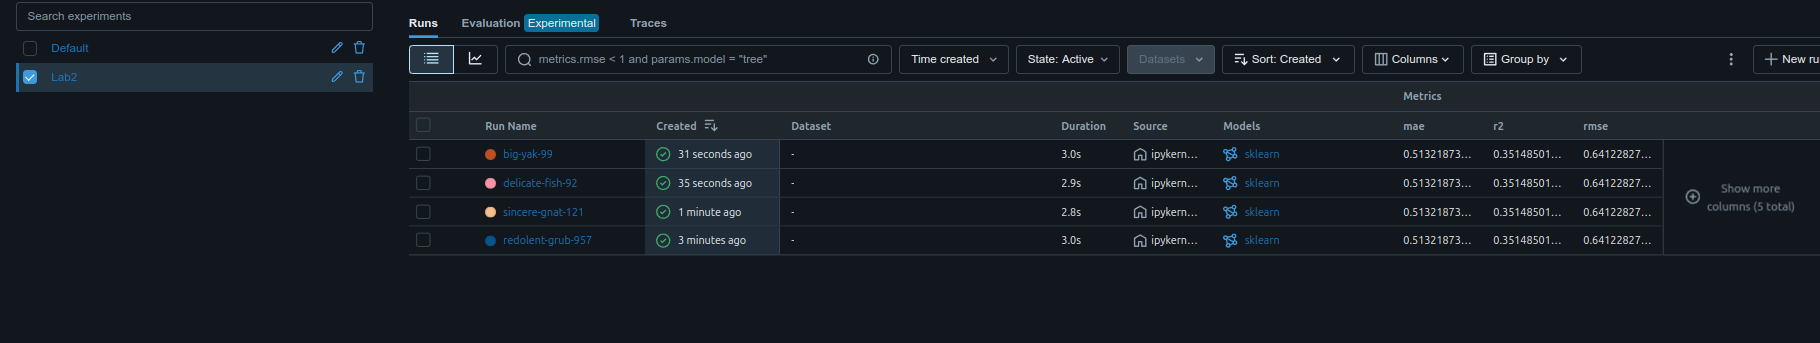